# Phenotypic Sensitivity to Parametric Changes

© 2018 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [4]:
import sys
sys.path.insert(0, '../../')
import numpy as np
import pandas as pd
import sympy
import bokeh.io
import bokeh.plotting
import mut.thermo
import mut.constants
bokeh.io.output_notebook()
sympy.init_printing()

Loading BokehJS ...

In this notebook, we examine the general relationship between phenotypic properties and their parametric changes,

$$
{\partial \text{phenotype} \over \partial \text{parameter}} \tag{1}.
$$

We've looked at the sensitivity of the fold-change (phenotype) depends on the 


In [ ]:
# Define variables. 
delta_ep = sympy.Symbol(r'\Delta\Delta\varepsilon_{RA}')
epAI_wt = sympy.Symbol(r'\Delta\varepsilon_{AI}^{(wt)}')
epAI_mut = sympy.Symbol(r'\Delta\varepsilon_{AI}^{(mut)}')
c = sympy.Symbol(r'c')
ka_wt = sympy.Symbol(r'K_A^{(wt)}')
ki_wt = sympy.Symbol(r'K_I^{(wt)}')
ka_mut = sympy.Symbol(r'K_A^{(mut)}')
ki_mut = sympy.Symbol(r'K_I^{(mut)}')
r_nns = sympy.Symbol(r'{R \over N_{NS}}')
pact_wt = ((1 + c / ka_wt)**2 / ((1 + c / ka_wt)**2 + sympy.exp(epAI_mut) * (1 + c / ki_wt)**2))
pact_mut = ((1 + c / ka_mut)**2 / ((1 + c / ka_mut)**2 + sympy.exp(epAI_mut) * (1 + c / ki_mut)**2))

log_pact = sympy.log(pact_mut / pact_wt)
deltaF = log_pact - delta_ep
sympy.integrate(deltaF, c)
# Define the fold-change function. 
# fc = (1 + p_act * r_nns * sympy.exp(-ep_RA))**-1
# sympy.diff(fc, ep_RA)

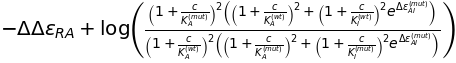

In [27]:
deltaF

In [23]:
def deltaF_sat(mut_allo, mut_epRA, wt_dict):
    """
    Computes deltaF in the limit of saturation. 
    """
    # Break it into pieces. 
    wt_allo = np.exp(-wt_dict['ep_AI']) * (wt_dict['Ka']/wt_dict['Ki'])**wt_dict['n_sites']
    pact_wt = (1 + wt_allo)
    return np.log(pact_wt / (1 + mut_allo)) - (mut_epRA - wt_dict['ep_RA'])